## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences (Universal Tagset)
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# First few tagged (5) sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting nltk_data into train_set (95%) and test_set (5%)
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:2])

3718
196
[[('William', 'NOUN'), ('Gates', 'NOUN'), ('and', 'CONJ'), ('Paul', 'NOUN'), ('Allen', 'NOUN'), ('in', 'ADP'), ('1975', 'NUM'), ('developed', 'VERB'), ('an', 'DET'), ('early', 'ADJ'), ('language-housekeeper', 'ADJ'), ('system', 'NOUN'), ('for', 'ADP'), ('PCs', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('Gates', 'NOUN'), ('became', 'VERB'), ('an', 'DET'), ('industry', 'NOUN'), ('billionaire', 'NOUN'), ('six', 'NUM'), ('years', 'NOUN'), ('after', 'ADP'), ('IBM', 'NOUN'), ('adapted', 'VERB'), ('one', 'NUM'), ('of', 'ADP'), ('these', 'DET'), ('versions', 'NOUN'), ('in', 'ADP'), ('1981', 'NUM'), ('.', '.')], [('But', 'CONJ'), ('the', 'DET'), ('court', 'NOUN'), ('disagreed', 'VERB'), ('.', '.')]]


#### So there are 3718 sentences in training set and 196 sentences in test set 

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95496

#### There are 95862 tagged words in training dataset

In [6]:
train_tagged_words[:10]

[('William', 'NOUN'),
 ('Gates', 'NOUN'),
 ('and', 'CONJ'),
 ('Paul', 'NOUN'),
 ('Allen', 'NOUN'),
 ('in', 'ADP'),
 ('1975', 'NUM'),
 ('developed', 'VERB'),
 ('an', 'DET'),
 ('early', 'ADJ')]

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['William',
 'Gates',
 'and',
 'Paul',
 'Allen',
 'in',
 '1975',
 'developed',
 'an',
 'early']

In [9]:
# Count of vocabulary
V = set(tokens)
print(len(V))

12070


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
# Unique Tags
print(T)

{'DET', 'VERB', '.', 'X', 'PRON', 'PRT', 'ADV', 'ADJ', 'ADP', 'NUM', 'NOUN', 'CONJ'}


#### There are 12 unique tags used in training dataset, Total no of occurences of tag in the corpus is listed below.

In [11]:
# To find the most frequent tag in the corpus
# to count the frequency of elements in a list, We can use the Counter() class from collections as shown below

from collections import Counter
T_counts = Counter([pair[1] for pair in train_tagged_words])
T_counts.most_common(12)

[('NOUN', 27400),
 ('VERB', 12884),
 ('.', 11118),
 ('ADP', 9313),
 ('DET', 8264),
 ('X', 6273),
 ('ADJ', 6081),
 ('NUM', 3336),
 ('PRT', 3058),
 ('ADV', 3009),
 ('PRON', 2612),
 ('CONJ', 2148)]

### Emission Probabilities

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# generally
print("\n", "Emission Probabilities for word -> generally")
print(word_given_tag('generally', 'ADV'))
print(word_given_tag('generally', 'VERB')) 

# dollars
print("\n", "Emission Probabilities for word -> dollars")
print(word_given_tag('dollars', 'NOUN'))
print(word_given_tag('dollars', 'ADJ')) 



 Emission Probabilities for word -> generally
(12, 3009)
(0, 12884)

 Emission Probabilities for word -> dollars
(16, 27400)
(0, 6081)


### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# examples
print("\n", "Transition Probabilities : T1 -> T2")

print("\n", "Transition Probabilities : ADJ -> NOUN")
print(t2_given_t1(t2='NOUN', t1='ADJ'))

print("\n", "Transition Probabilities : NOUN -> VERB")
print(t2_given_t1('VERB', 'NOUN')) 

print("\n", "Transition Probabilities : VERB -> ADV")
print(t2_given_t1('ADV', 'VERB')) 



 Transition Probabilities : T1 -> T2

 Transition Probabilities : ADJ -> NOUN
(4259, 6081)

 Transition Probabilities : NOUN -> VERB
(4020, 27400)

 Transition Probabilities : VERB -> ADV
(1053, 12884)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[5.20329131e-03, 3.96902226e-02, 1.71829630e-02, 4.59825732e-02,
        3.50919645e-03, 2.42013557e-04, 1.28267184e-02, 2.05832526e-01,
        9.19651520e-03, 2.21442394e-02, 6.37584686e-01, 6.05033885e-04],
       [1.33809373e-01, 1.69124499e-01, 3.51598896e-02, 2.17246190e-01,
        3.64017375e-02, 3.12791057e-02, 8.17292780e-02, 6.56628385e-02,
        9.04222280e-02, 2.28966158e-02, 1.10757530e-01, 5.51071111e-03],
       [1.73142657e-01, 8.88649002e-02, 9.28224474e-02, 2.74329912e-02,
        6.59291223e-02, 2.33855005e-03, 5.26173785e-02, 4.45223972e-02,
        9.07537341e-02, 8.00503716e-02, 2.23781258e-01, 5.76542541e-02],
       [5.43599539e-02, 2.05802649e-01, 1.62282795e-01, 7.46054500e-02,
        5.64323291e-02, 1.83803603e-01, 2.58249640e-02, 1.72166433e-02,
        1.43631443e-01, 2.86944048e-03, 6.29682764e-02, 1.02024553e-02],
       [9.57120955e-03, 4.86983150e-01, 3.98162343e-02, 9.34150070e-02,
        7.65696773e-03, 1.26339970e-02, 3.36906575e-02, 7.19

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [20]:
tags_df

,DET,VERB,.,X,PRON,PRT,ADV,ADJ,ADP,NUM,NOUN,CONJ
DET,0.005203,0.039690,0.017183,0.045983,0.003509,0.000242,0.012827,0.205833,0.009197,0.022144,0.637585,0.000605
VERB,0.133809,0.169124,0.035160,0.217246,0.036402,0.031279,0.081729,0.065663,0.090422,0.022897,0.110758,0.005511
.,0.173143,0.088865,0.092822,0.027433,0.065929,0.002339,0.052617,0.044522,0.090754,0.080050,0.223781,0.057654
X,0.054360,0.205803,0.162283,0.074605,0.056432,0.183804,0.025825,0.017217,0.143631,0.002869,0.062968,0.010202
PRON,0.009571,0.486983,0.039816,0.093415,0.007657,0.012634,0.033691,0.071975,0.022205,0.006891,0.209801,0.005360
PRT,0.102354,0.397973,0.043819,0.013407,0.018313,0.001962,0.009483,0.085677,0.020275,0.057881,0.246566,0.002289
ADV,0.069126,0.347291,0.136923,0.023264,0.014955,0.014290,0.079428,0.128614,0.116650,0.031240,0.031240,0.006979
ADJ,0.004933,0.011511,0.065943,0.021871,0.000658,0.010689,0.004933,0.064792,0.076139,0.020885,0.700378,0.017267
ADP,0.324385,0.008590,0.040052,0.034146,0.068829,0.001396,0.012993,0.107377,0.016751,0.063352,0.321379,0.000752
NUM,0.003297,0.017986,0.120204,0.211930,0.001799,0.028477,0.002398,0.032374,0.035671,0.183753,0.349221,0.012890


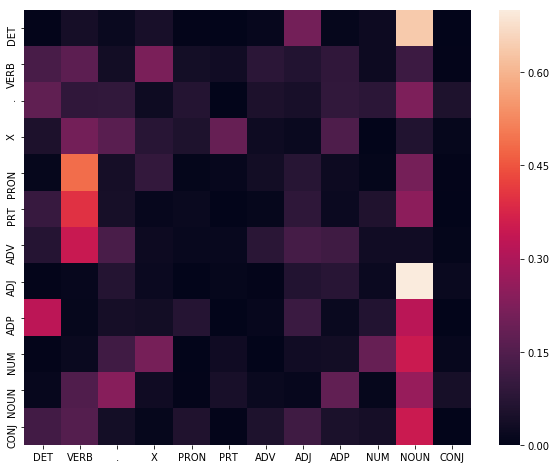

In [21]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(10, 8))
sns.heatmap(tags_df)
plt.show()


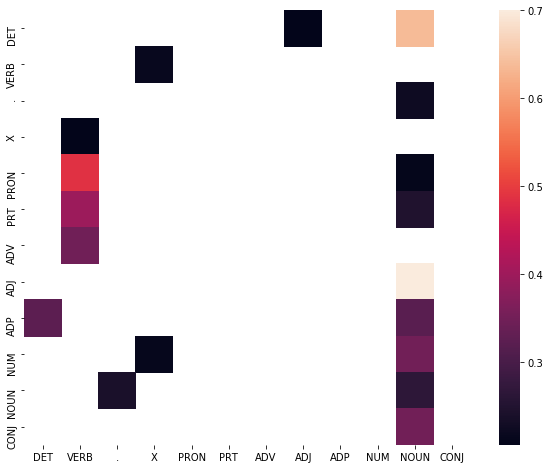

In [22]:
# frequent tags
# filter the df to get P(t2, t1) > 0.2
tags_frequent = tags_df[tags_df>0.2]
plt.figure(figsize=(10, 8))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [23]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [24]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test_set dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('Both', 'DET'),
  ('sides', 'NOUN'),
  ('are', 'VERB'),
  ('taking', 'VERB'),
  ('action', 'NOUN'),
  ('.', '.'),
  ("''", '.')],
 [('In', 'ADP'),
  ('CAT', 'NOUN'),
  ('sections', 'NOUN'),
  ('where', 'ADV'),
  ('students', 'NOUN'),
  ("'", 'PRT'),
  ('knowledge', 'NOUN'),
  ('of', 'ADP'),
  ('two-letter', 'ADJ'),
  ('consonant', 'ADJ'),
  ('sounds', 'NOUN'),
  ('is', 'VERB'),
  ('tested', 'VERB'),
  ('*-1', 'X'),
  ('*T*-2', 'X'),
  (',', '.'),
  ('the', 'DET'),
  ('authors', 'NOUN'),
  ('noted', 'VERB'),
  ('that', 'ADP'),
  ('Scoring', 'NOUN'),
  ('High', 'NOUN'),
  ('concentrated', 'VERB'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('same', 'ADJ'),
  ('sounds', 'NOUN'),
  ('that', 'ADP'),
  ('the', 'DET'),
  ('test', 'NOUN'),
  ('does', 'VERB'),
  ('*?*', 'X'),
  ('*T*-4', 'X'),
  ('--', '.'),
  ('to', 'ADP'),
  ('the', 'DET'),
  ('exclusion', 'NOUN'),
  ('of', 'ADP'),
  ('other', 'ADJ'),
  ('sounds', 'NOUN'),
  ('that', 'ADP'),
  ('fifth', 'ADJ'),
  ('graders', 'NOUN

In [25]:
# tagging the test_set data sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [26]:
print("Time taken in seconds: ", difference)
print(tagged_seq) 

Time taken in seconds:  40.498812437057495
[('``', '.'), ('Both', 'DET'), ('sides', 'NOUN'), ('are', 'VERB'), ('taking', 'VERB'), ('action', 'NOUN'), ('.', '.'), ("''", '.'), ('In', 'ADP'), ('CAT', 'NOUN'), ('sections', 'NOUN'), ('where', 'ADV'), ('students', 'NOUN'), ("'", 'PRT'), ('knowledge', 'NOUN'), ('of', 'ADP'), ('two-letter', 'DET'), ('consonant', 'DET'), ('sounds', 'VERB'), ('is', 'VERB'), ('tested', 'VERB'), ('*-1', 'X'), ('*T*-2', 'X'), (',', '.'), ('the', 'DET'), ('authors', 'NOUN'), ('noted', 'VERB'), ('that', 'ADP'), ('Scoring', 'NOUN'), ('High', 'NOUN'), ('concentrated', 'VERB'), ('on', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('sounds', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('test', 'NOUN'), ('does', 'VERB'), ('*?*', 'X'), ('*T*-4', 'X'), ('--', '.'), ('to', 'PRT'), ('the', 'DET'), ('exclusion', 'DET'), ('of', 'ADP'), ('other', 'ADJ'), ('sounds', 'VERB'), ('that', 'ADP'), ('fifth', 'ADJ'), ('graders', 'NOUN'), ('should', 'VERB'), ('know', 'VERB'), ('*T*-3', 'X'), ('

In [27]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [28]:
Viterbi_Initial_Accuracy_on_TEST_SET = len(check)/len(tagged_seq)

In [29]:
print('Viterbi Algorithm Accuracy: ', round(Viterbi_Initial_Accuracy_on_TEST_SET *100,2) , " %")

Viterbi Algorithm Accuracy:  88.51  %


In [30]:
# To find Incorrectly tagged words in test_set data
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [31]:
incorrect_tagged_cases

[[('of', 'ADP'), (('two-letter', 'DET'), ('two-letter', 'ADJ'))],
 [('two-letter', 'ADJ'), (('consonant', 'DET'), ('consonant', 'ADJ'))],
 [('consonant', 'ADJ'), (('sounds', 'VERB'), ('sounds', 'NOUN'))],
 [('same', 'ADJ'), (('sounds', 'VERB'), ('sounds', 'NOUN'))],
 [('--', '.'), (('to', 'PRT'), ('to', 'ADP'))],
 [('the', 'DET'), (('exclusion', 'DET'), ('exclusion', 'NOUN'))],
 [('other', 'ADJ'), (('sounds', 'VERB'), ('sounds', 'NOUN'))],
 [('a', 'DET'), (('distant', 'DET'), ('distant', 'ADJ'))],
 [('frozen', 'VERB'), (('foods', 'DET'), ('foods', 'NOUN'))],
 [('for', 'ADP'), (('Freshbake', 'DET'), ('Freshbake', 'NOUN'))],
 [('and', 'CONJ'), (('wound', 'NOUN'), ('wound', 'VERB'))],
 [('.', '.'), (('SHAREDATA', 'DET'), ('SHAREDATA', 'NOUN'))],
 [('will', 'VERB'), (('amend', 'DET'), ('amend', 'VERB'))],
 [('to', 'PRT'), (('delete', 'DET'), ('delete', 'VERB'))],
 [('to', 'PRT'), (('book', 'NOUN'), ('book', 'VERB'))],
 [('leaving', 'VERB'), (('stocks', 'NOUN'), ('stocks', 'ADV'))],
 [('sto

#### Now let us use the "Test sentences.txt" file and find how the unknown words in the file (unknown words, which are not present in Universal corpus) are tagged.  

In [32]:
f = open('Test_sentences.txt', "r")
lines = f.readlines()
f.close()

test_sentences_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_sentences_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [33]:
test_sentences_words=[test_sentences_tokens for line in test_sentences_lines for test_sentences_tokens in word_tokenize(line)]
test_sentences_words[:5]

['Android', 'is', 'a', 'mobile', 'operating']

In [34]:
# Find the list of word in "Test sentences.txt" file which are not present in Universal Treebank Corpus (tokens Vocabulary)
words_not_in_corpus = list(set(test_sentences_words) - set(tokens))
words_not_in_corpus 

['FIFA',
 'Android',
 'contested',
 'interact',
 'personality',
 'messages',
 'Google',
 'tournament',
 'arriving',
 '2011',
 'domineering',
 'Satellite',
 '2015',
 'firehose',
 '2018',
 'invited',
 '21st',
 '2013',
 'OS',
 'NASA',
 'worldwide',
 'Cup',
 'trips',
 'tweets',
 'online',
 'Twitter',
 'smartphones',
 'ICESAT-2']

In [35]:
# Applying Viterbi algorithm on words from Test_sentences.txt file
test_sentences_tagged =[]
for line in test_sentences_lines:
    test_sentences_tagged = test_sentences_tagged + list(Viterbi(word_tokenize(line)))
test_sentences_tagged

[('Android', 'DET'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.'),
 ('Android', 'DET'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'DET'),
 ('worldwide', 'DET'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'DET'),
 ('.', '.'),
 ('Google', 'DET'),
 ('and', 'CONJ'),
 ('Twitter', 'DET'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'DET'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'DET'),
 ("'s", 'VERB'),
 ('firehose', 'DET'),
 ('.', '.'),
 ('Twitter', 'DET'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'DET'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NO

In [36]:
# Get unknown words from Test_sentences.txt file, which is not available in universal corpus 
# and the wrong tags predicted by initial Viterbi Algorithm for those unknown words.
[tup for tup in test_sentences_tagged for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'DET'),
 ('Google', 'DET'),
 ('Android', 'DET'),
 ('OS', 'DET'),
 ('worldwide', 'DET'),
 ('smartphones', 'DET'),
 ('2011', 'DET'),
 ('2013', 'DET'),
 ('Google', 'DET'),
 ('Twitter', 'DET'),
 ('2015', 'DET'),
 ('Google', 'DET'),
 ('Twitter', 'DET'),
 ('firehose', 'DET'),
 ('Twitter', 'DET'),
 ('online', 'DET'),
 ('interact', 'DET'),
 ('messages', 'DET'),
 ('tweets', 'DET'),
 ('domineering', 'DET'),
 ('personality', 'DET'),
 ('2018', 'DET'),
 ('FIFA', 'DET'),
 ('Cup', 'DET'),
 ('21st', 'DET'),
 ('FIFA', 'DET'),
 ('Cup', 'DET'),
 ('tournament', 'DET'),
 ('contested', 'DET'),
 ('Cup', 'DET'),
 ('trips', 'DET'),
 ('arriving', 'DET'),
 ('NASA', 'DET'),
 ('invited', 'DET'),
 ('ICESAT-2', 'DET'),
 ('Satellite', 'DET')]

# Solve the problem of unknown words

### Viterbi algorithm modification to handle unknown words by using Lexicon Tagger and Rule Based Tagger

# Technique 1
#### Lexicon (Unigram) Tagger

In [37]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.904054054054054

#### Lexicon (BiGram) Tagger

In [38]:
# BiGram tagger
bigram_tagger = nltk.BigramTagger(train_set)
bigram_tagger.evaluate(test_set)

0.211003861003861

# Technique 2
#### Rule-Based (Regular Expression) Tagger 

In [39]:
# specify patterns for Rule based tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [40]:
rule_based_tagger = nltk.RegexpTagger(patterns) 

# Combining Technique 1 and Technique 2

#### Creating lexicon_tagger (UniGram) backed up by the rule-based tagger

In [41]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger. Since Lexicon (Unigram) Tagger seems to perform fairly well.
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

In [42]:
# Viterbi Algorithm to handle unknown words (Which has emission probability = zero)
def Viterbi_Modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
        # Handling unknown words, by using lexicon_tagger which is backed up by rule_based_tagger
        if(pmax==0):
            state_max = lexicon_tagger.tag([word])[0][1]
        else:
            state_max = T[p.index(pmax)] 
            
        state.append(state_max)
    return list(zip(words, state))


### Evaluating tagging accuracy - On Test_sentences.txt

In [43]:
# Get the new tags for sentences in "Test sentences.txt" using the new modified Viterbi algorithm
test_sentences_tagged =[]
for line in test_sentences_lines:
    test_sentences_tagged = test_sentences_tagged + list( Viterbi_Modified(word_tokenize(line)) )
test_sentences_tagged

# Display the new tags for the unknown words which was present in "Test sentences.txt"
[tup for tup in test_sentences_tagged for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'NOUN'),
 ('Google', 'NOUN'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'VERB'),
 ('2011', 'NUM'),
 ('2013', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('firehose', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'VERB'),
 ('tweets', 'NOUN'),
 ('domineering', 'VERB'),
 ('personality', 'NOUN'),
 ('2018', 'NUM'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'VERB'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'VERB'),
 ('NASA', 'NOUN'),
 ('invited', 'VERB'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN')]

## Evaluating tagging accuracy (On Test_Set data)

In [44]:
# Tagging the test_set data sentences using Modified Viterbi Algorithm 
start = time.time()
tagged_seq_Modified = Viterbi_Modified(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  40.340768337249756


In [45]:
# Modified Viterbi Algorithm Accuracy
check_Modified = [i for i, j in zip(tagged_seq_Modified, test_run_base) if i == j] 

Viterbi_Modified_Accuracy_on_TEST_SET = len(check_Modified)/len(tagged_seq_Modified)

print('Modified Viterbi Algorithm Accuracy: ', Viterbi_Modified_Accuracy_on_TEST_SET*100)

Modified Viterbi Algorithm Accuracy:  91.21621621621621


In [46]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq_Modified, test_run_base)) if j[0] != j[1]]

[(('two-letter', 'NOUN'), ('two-letter', 'ADJ')),
 (('consonant', 'NOUN'), ('consonant', 'ADJ')),
 (('sounds', 'VERB'), ('sounds', 'NOUN')),
 (('sounds', 'VERB'), ('sounds', 'NOUN')),
 (('to', 'PRT'), ('to', 'ADP')),
 (('sounds', 'VERB'), ('sounds', 'NOUN')),
 (('distant', 'NOUN'), ('distant', 'ADJ')),
 (('wound', 'NOUN'), ('wound', 'VERB')),
 (('amend', 'NOUN'), ('amend', 'VERB')),
 (('delete', 'NOUN'), ('delete', 'VERB')),
 (('book', 'NOUN'), ('book', 'VERB')),
 (('stocks', 'NOUN'), ('stocks', 'ADV')),
 (('up', 'PRT'), ('up', 'ADP'))]

## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

##### Original vanilla Viterbi algorithm Accuracy

In [47]:
# Original Viterbi Algorithm Accuracy
print('Original Viterbi Algorithm Accuracy: ', round(Viterbi_Initial_Accuracy_on_TEST_SET *100,2) , " %")

Original Viterbi Algorithm Accuracy:  88.51  %


##### Modified Vanilla Viterbi algorithm Accuracy : Combining lexicon_tagger (UniGram) backed up by the rule-based tagger

In [48]:
print('Modified Viterbi Algorithm Accuracy: ', round(Viterbi_Modified_Accuracy_on_TEST_SET*100,2) , " %")

Modified Viterbi Algorithm Accuracy:  91.22  %


In [49]:
Accuracy_Increase = round(Viterbi_Modified_Accuracy_on_TEST_SET*100 - Viterbi_Initial_Accuracy_on_TEST_SET*100,2) 

In [50]:
print('\033[1m' + 'Accuracy has increased by Accuracy_Increase by ' + str(Accuracy_Increase) + ' %')

Accuracy has increased by Accuracy_Increase by 2.7 %


In [51]:
# Display the new tags for the unknown words which was present in "Test sentences.txt"
[tup for tup in test_sentences_tagged for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'NOUN'),
 ('Google', 'NOUN'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'VERB'),
 ('2011', 'NUM'),
 ('2013', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('firehose', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'VERB'),
 ('tweets', 'NOUN'),
 ('domineering', 'VERB'),
 ('personality', 'NOUN'),
 ('2018', 'NUM'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'VERB'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'VERB'),
 ('NASA', 'NOUN'),
 ('invited', 'VERB'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN')]

## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### From Test_sentences.txt, Un-known words are identified correctly 
##### Android, Google, Android, FIFA, NASA are identified as NOUN correctly
##### 2011, 2013, 2015 are identified as NUM
##### domineering, contested, arriving are identified as VERB
# -------------------------------------------------------------------
### From test_set, words are identified correctly 
##### Zayed has been properly tagged as NOUN
##### T-143 has been properly tagged as X
##### newest has been properly tagged as ADJ
##### accompany has been properly tagged as VERB
##### plan has been properly tagged as VERB
##### sweepstakes has been properly tagged as NOUN
# -------------------------------------------------------------------